In [1]:
from DataClean import Data
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from util import Data_twist,acc_kf,recall_kf,percision_kf
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# data_edit = Data('./alln/','edit distance','basic',tag=True).df
# data_jacard = Data('./alln/','jacard','basic',tag=True).df
# data_w2v = Data('./alln/','word2vec','basic').df
data_edit = Data('./all Projects/Data_NoLevel/','edit distance', 'basic', tag=True, data_structure='clean').df
data_edit = Data_twist(data_edit)
# data_jacard = Data('./all Projects/Data_NoLevel/','jacard','basic',tag=True,data_structure='clean').df

Data Merge Finished. 499 files are merged.


In [2]:
data_edit

,testClassName,testMethodName,potentialTargetQualifiedName,AAA,Assert Distance,Name Similarity,Tag-Mock,Tag-New,Tag-Test,Tag-Get,Tag-Set
0,IterConfigUtilTest,test5,NEW org.apache.accumulo.core.conf.Configuratio...,0,18.0,5.0,0,1,0,0,0
1,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,17.0,5.0,0,0,0,0,1
2,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,16.0,5.0,0,0,0,0,1
3,IterConfigUtilTest,test5,org.apache.accumulo.core.conf.ConfigurationCop...,0,15.0,5.0,0,0,0,0,1
4,IterConfigUtilTest,test5,NEW org.apache.hadoop.io.Text(S...,0,14.0,5.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
19347,ConsulDynamicConfigurationTest,testGetConfig,ASSERT org.junit.jupiter.api.Assertions.assert...,2,0.0,6.0,0,0,0,0,0
19348,ConsulDynamicConfigurationTest,testGetConfig,org.apache.dubbo.common.config.configcenter.Dy...,1,1.0,4.0,0,0,0,1,0
19349,ConsulDynamicConfigurationTest,testGetConfig,ASSERT org.junit.jupiter.api.Assertions.assert...,2,0.0,6.0,0,0,0,0,0
19350,ConsulDynamicConfigurationTest,testGetConfig,org.apache.dubbo.common.config.configcenter.Dy...,1,1.0,4.0,0,0,0,1,0


# RAW

Class=0, n=12388 (64.014%)
Class=1, n=1024 (5.291%)
Class=2, n=5940 (30.695%)


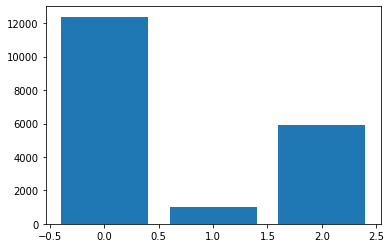

In [3]:
## RAW, shows the original distribution of AAA kinds
from collections import Counter
y = np.array(data_edit.AAA)
X = np.array(data_edit.drop(labels=['testClassName','testMethodName','potentialTargetQualifiedName','AAA'], axis=1))

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [4]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)

# TODO:归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_edit_minmax = pd.DataFrame(data=scaler.fit_transform(X))
target_df = pd.DataFrame(data=y)

In [5]:
# XGB
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dtrain = xgb.DMatrix(data=x_train,label=y_train)
        dtest = xgb.DMatrix(data=x_test,label=y_test)

        param = {'max_depth':5, 'eta':0.5, 'verbosity':1, 'objective':'multi:softprob', 'num_class':3}
        param['nthread'] = 4
        param['seed'] = 100
        num_round = 100
        bst_without_evallist = xgb.train(param, dtrain, num_round)
        ans = bst_without_evallist.predict(dtest)
        prob = np.argmax(ans, axis=1)
      
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
xgb_result_df = pd.core.frame.DataFrame(dic)
xgb_result_df.to_csv('./smote/pre_smote/xgb_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [6]:
# RF
from sklearn.ensemble import RandomForestClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        rf = RandomForestClassifier(oob_score=True)
        rf.fit(x_train, y_train.values.ravel())
        rf_pred = rf.predict(x_test)
   
        prob = rf_pred

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
rf_result_df = pd.core.frame.DataFrame(dic)
rf_result_df.to_csv('./smote/pre_smote/rf_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [7]:
# DT
from sklearn.tree import DecisionTreeClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dt = DecisionTreeClassifier()
        dt.fit(x_train, y_train.values.ravel())

        prob = dt.predict(x_test)  
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
dt_result_df = pd.core.frame.DataFrame(dic)
dt_result_df.to_csv('./smote/pre_smote/dt_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [8]:
# SVM oneVSone
# A=B=C=D=0; # 票数初始化
# (A，B)-classifier 如果是A win，则A=A+1;otherwise, B=B+1;
# (A，C)-classifier 如果是A win，则A=A+1;otherwise, C=C+1;
# …
# (C，D)-classifier 如果是A win，则C=C+1;otherwise, D=D+1;
# The decision is the Max(A，B，C，D)

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        nb = OneVsOneClassifier(SVC())
        nb.fit(x_train,y_train.values.ravel())
        prob = nb.predict(x_test)  

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
nb_result_df = pd.core.frame.DataFrame(dic)
nb_result_df.to_csv('./smote/pre_smote/svm_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [9]:
# LR
from sklearn.linear_model import LogisticRegression

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        lr = LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')
        lr.fit(x_train, y_train.values.ravel())
        lr_pred = lr.predict(x_test)
        # print(rf_pred)
        prob = lr_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
lr_result_df = pd.core.frame.DataFrame(dic)
lr_result_df.to_csv('./smote/pre_smote/lr_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [10]:
from sklearn.neural_network import MLPClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        bpnn = MLPClassifier(solver='adam',alpha=1e-5,hidden_layer_sizes=[10,10],activation='relu',max_iter=1000)
        bpnn.fit(x_train, y_train.values.ravel())
        bpnn_pred = bpnn.predict(x_test)
        # print(rf_pred)
        prob = bpnn_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
bpnn_result_df = pd.core.frame.DataFrame(dic)
bpnn_result_df.to_csv('./smote/pre_smote/bpnn_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


# SMOTE

Class=0, n=12388 (33.333%)
Class=1, n=12388 (33.333%)
Class=2, n=12388 (33.333%)


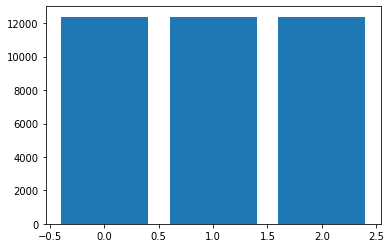

In [11]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [12]:
# Kfold
kf = KFold(n_splits=10,shuffle=True)
# 归一化

scaler = MinMaxScaler()
data_edit_minmax = pd.DataFrame(data=scaler.fit_transform(X))
target_df = pd.DataFrame(data=y)

In [13]:
# XGB
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dtrain = xgb.DMatrix(data=x_train,label=y_train)
        dtest = xgb.DMatrix(data=x_test,label=y_test)

        param = {'max_depth':5, 'eta':0.5, 'verbosity':1, 'objective':'multi:softprob', 'num_class':3}
        param['nthread'] = 4
        param['seed'] = 100
        num_round = 100
        bst_without_evallist = xgb.train(param, dtrain, num_round)
        ans = bst_without_evallist.predict(dtest)
        prob = np.argmax(ans, axis=1)
      
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
xgb_result_df = pd.core.frame.DataFrame(dic)
xgb_result_df.to_csv('./smote/post_smote/xgb_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [14]:
# RF
from sklearn.ensemble import RandomForestClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        rf = RandomForestClassifier(oob_score=True)
        rf.fit(x_train, y_train.values.ravel())
        rf_pred = rf.predict(x_test)
   
        prob = rf_pred

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
rf_result_df = pd.core.frame.DataFrame(dic)
rf_result_df.to_csv('./smote/post_smote/rf_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [15]:
# DT
from sklearn.tree import DecisionTreeClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        dt = DecisionTreeClassifier()
        dt.fit(x_train, y_train.values.ravel())

        prob = dt.predict(x_test)  
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
dt_result_df = pd.core.frame.DataFrame(dic)
dt_result_df.to_csv('./smote/post_smote/dt_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [16]:
# SVM oneVSone
# A=B=C=D=0; # 票数初始化
# (A，B)-classifier 如果是A win，则A=A+1;otherwise, B=B+1;
# (A，C)-classifier 如果是A win，则A=A+1;otherwise, C=C+1;
# …
# (C，D)-classifier 如果是A win，则C=C+1;otherwise, D=D+1;
# The decision is the Max(A，B，C，D)

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        nb = OneVsOneClassifier(SVC())
        nb.fit(x_train,y_train.values.ravel())
        prob = nb.predict(x_test)  

        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
nb_result_df = pd.core.frame.DataFrame(dic)
nb_result_df.to_csv('./smote/post_smote/svm_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [17]:
# LR
from sklearn.linear_model import LogisticRegression

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        lr = LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')
        lr.fit(x_train, y_train.values.ravel())
        lr_pred = lr.predict(x_test)
        # print(rf_pred)
        prob = lr_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
lr_result_df = pd.core.frame.DataFrame(dic)
lr_result_df.to_csv('./smote/post_smote/lr_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


In [18]:
#BPNN
from sklearn.neural_network import MLPClassifier

ar_recall_list = []
ar_precision_list =[]
ac_recall_list = []
ac_precision_list =[]
as_recall_list = []
as_precision_list =[]
rounds = 0
for i in range(10):
    rounds += 1
    for train_index, test_index in kf.split(data_edit_minmax):
        x_train, x_test = data_edit_minmax.iloc[train_index],data_edit_minmax.iloc[test_index]
        y_train, y_test = target_df.iloc[train_index],target_df.iloc[test_index]
    
        bpnn = MLPClassifier(solver='adam',alpha=1e-5,hidden_layer_sizes=[10,10],activation='relu',max_iter=1000)
        bpnn.fit(x_train, y_train.values.ravel())
        bpnn_pred = bpnn.predict(x_test)
        # print(rf_pred)
        prob = bpnn_pred
        
        arrange_recall,action_recall,assert_recall =recall_kf(prob,y_test.values)
        arrange_pre,action_pre,assert_pre = percision_kf(prob,y_test.values)
        ar_recall_list.append(arrange_recall)
        ar_precision_list.append(arrange_pre)
        ac_recall_list.append(action_recall)
        ac_precision_list.append(action_pre)
        as_recall_list.append(assert_recall)
        as_precision_list.append(assert_pre)
    print('Round {0}'.format(rounds))
dic = {'arrange_recall':ar_recall_list,'arrange_precision':ar_precision_list,'action_recall':ac_recall_list,'action_precision':ac_precision_list,'assert_recall':as_recall_list,'assert_precision':as_precision_list}
bpnn_result_df = pd.core.frame.DataFrame(dic)
bpnn_result_df.to_csv('./smote/post_smote/bpnn_result.csv',index=False)

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10


# F1 Generate

In [19]:
## F1 and Avarage and Ttest
### f1 = 2*(precision*recall)/(precision+recall)
from scipy import stats
import os

def gen_p(data1,data2):
    '''data should be numpy array'''
    equal_var = True
    if stats.levene(data1,data2)[1] < 0.05:
        equal_var = False
    return stats.ttest_ind(data1,data2,equal_var)[1]

def gen_f1(p,r):
    # if p+r == 0:
    #     print('yes')
    #     print(p)
    #     print(r)
    return 2*(p*r)/(p+r)

def findAllFile(folder_path):
    for root, ds, fs in os.walk(folder_path):
        for f in fs:
            fullname = os.path.join(root, f)
            yield fullname
########## File list ##############
all_presmote_file_list = []
all_postsmote_file_list = []

for i in findAllFile('./smote/pre_smote'):
    if i == './smote/pre_smote/.DS_Store': #TODO: need fix
        continue
    else:
        all_presmote_file_list.append(i)
        print(i)

for i in findAllFile('./smote/post_smote'):
    if i == './smote/post_smote/.DS_Store': #TODO: need fix
        continue
    else:
        all_postsmote_file_list.append(i)
        print(i)
################### F1 genaration fot all the smote files ############
all_list = all_presmote_file_list + all_postsmote_file_list
for file in all_list:
    processing_df = pd.read_csv(file)
    processing_df.insert(2,'arrange_f1',0)
    processing_df.insert(5,'action_f1',0)
    processing_df.insert(8,'assert_f1',0)

    for _ in range(100):
        try:
            processing_df.loc[_,'arrange_f1'] = gen_f1(processing_df['arrange_precision'][_],processing_df['arrange_recall'][_])
            processing_df.loc[_,'action_f1'] = gen_f1(processing_df['action_precision'][_],processing_df['action_recall'][_])
            processing_df.loc[_,'assert_f1'] = gen_f1(processing_df['assert_precision'][_],processing_df['assert_recall'][_])
        except Exception as e:
            print(e)
            print('ERROR FILE: {}'.format(file))
    
    name = './smote/f1/'+file.split('/')[-2] + '/' +file.split('/')[-1]
    processing_df.to_csv(name,index=False)


./smote/pre_smote/lr_result.csv
./smote/pre_smote/svm_result.csv
./smote/pre_smote/dt_result.csv
./smote/pre_smote/bpnn_result.csv
./smote/pre_smote/rf_result.csv
./smote/pre_smote/xgb_result.csv
./smote/post_smote/lr_result.csv
./smote/post_smote/svm_result.csv
./smote/post_smote/dt_result.csv
./smote/post_smote/bpnn_result.csv
./smote/post_smote/rf_result.csv
./smote/post_smote/xgb_result.csv


<ipython-input-19-c1ef29c74e9e>:18: RuntimeWarning: invalid value encountered in double_scalars
  return 2*(p*r)/(p+r)
